In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.auto import tqdm

import wandb
from wandb.integration.lightgbm import log_summary, wandb_callback



plt.style.use("ggplot")
warnings.filterwarnings("ignore")

c:\Users\337587\PlayGround\01_Personal\Kaggle\comp_002_GamePlayingStrength\venv01\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")

wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\337587\_netrc
wandb: Currently logged in as: shaka066 (shaka066-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [19]:
class CFG:
    # WandB
    experiment_name = "exp001"
    project = "um-game-playing-strength-of-mcts-variants"

    # Setting
    seed = 42
    train_path = "/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv"
    test_path = "/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv"
    submission_path = (
        "/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv"
    )

    # 実験関連
    target = ["utility_agent1"]
    n_splits = 5

    cat_cols = [
        "GameRulesetName",
        "agent1_param1",
        "agent1_param2",
        "agent1_param3",
        "agent1_param4",
        "agent2_param1",
        "agent2_param2",
        "agent2_param3",
        "agent2_param4",
    ]

    drop_cols = [
        "Id",
        "EnglishRules",
        "LudRules",
        "utility_agent1",
        "num_wins_agent1",
        "num_draws_agent1",
        "num_losses_agent1",
    ]

    # LightGBM
    objective = "regression"
    metric = "rmse"
    learning_rate = 0.1
    n_estimators = 10000
    stopping_rounds = 20
    log_evaluation = 100


# CFGクラスのインスタンスを作成
config = CFG()

In [20]:
# シード固定
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_everything(config.seed)

In [21]:
# クラスの属性を辞書に変換する関数
def class_to_dict(obj):
    return {k: getattr(obj, k) for k in dir(obj) if not k.startswith('__') and not callable(getattr(obj, k))}

In [22]:
class_to_dict(config)

{'cat_cols': ['GameRulesetName',
  'agent1_param1',
  'agent1_param2',
  'agent1_param3',
  'agent1_param4',
  'agent2_param1',
  'agent2_param2',
  'agent2_param3',
  'agent2_param4'],
 'drop_cols': ['Id',
  'EnglishRules',
  'LudRules',
  'utility_agent1',
  'num_wins_agent1',
  'num_draws_agent1',
  'num_losses_agent1'],
 'experiment_name': 'exp001',
 'learning_rate': 0.1,
 'log_evaluation': 100,
 'metric': 'rmse',
 'n_estimators': 10000,
 'n_splits': 5,
 'objective': 'regression',
 'project': 'um-game-playing-strength-of-mcts-variants',
 'seed': 42,
 'stopping_rounds': 20,
 'submission_path': '/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv',
 'target': ['utility_agent1'],
 'test_path': '/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv',
 'train_path': '/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv'}

In [24]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# ──────────────────────────────────────────
# 1. データ保存先とコンペのスラッグを指定
# ──────────────────────────────────────────
DATA_DIR = r"C:\Users\337587\PlayGround\01_Personal\Kaggle\comp_002_GamePlayingStrength\data"

# コンペのスラッグ(※URLの /competitions/ の後ろに当たる部分)
# 例: https://www.kaggle.com/competitions/um-game-playing-strength-of-mcts-variants
#                                                        ↑ここ
COMPETITION_SLUG = "um-game-playing-strength-of-mcts-variants"

# ──────────────────────────────────────────
# 2. データ取得関数
# ──────────────────────────────────────────
def fetch_competition_data(slug: str, target_dir: str):
    os.makedirs(target_dir, exist_ok=True)
    api = KaggleApi()
    api.authenticate()

    # コンペ全ファイルを一括ダウンロード (zipで落ちる)
    api.competition_download_files(slug, path=target_dir, quiet=False)

    # ダウンロードした zip をすべて展開
    for fname in os.listdir(target_dir):
        if fname.endswith(".zip"):
            zip_path = os.path.join(target_dir, fname)
            with zipfile.ZipFile(zip_path, "r") as z:
                z.extractall(target_dir)
            # 必要なら元zipを削除
            # os.remove(zip_path)

# 実行例
fetch_competition_data(COMPETITION_SLUG, DATA_DIR)


um-game-playing-strength-of-mcts-variants.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
config.train_path      = r"C:\Users\337587\PlayGround\01_Personal\Kaggle\comp_002_GamePlayingStrength\data\train.csv"
config.test_path       = r"C:\Users\337587\PlayGround\01_Personal\Kaggle\comp_002_GamePlayingStrength\data\test.csv"
    

df_train = pd.read_csv(config.train_path)
df_test  = pd.read_csv(config.test_path)
print(df_train.shape, df_test.shape)


(233234, 814) (3, 810)


<Axes: ylabel='Frequency'>

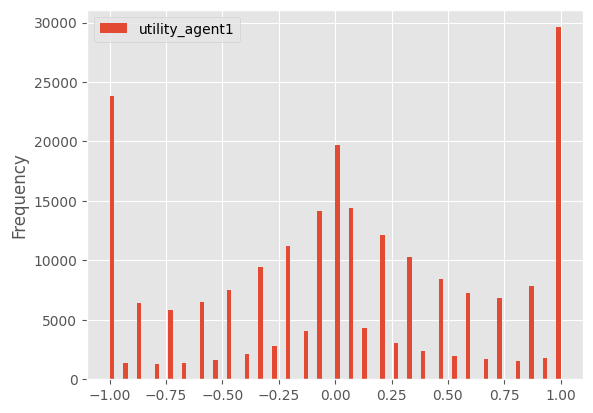

In [27]:
#ターゲットの分布を確認
df_train[config.target].plot.hist(bins=100)

In [28]:
def add_agent_type_cols(df):
    for col in ["agent1", "agent2"]:
        agent_add_cols = df[col].str.split("-", expand=True)
        agent_add_cols.columns = [
            f"{col}_param0",
            f"{col}_param1",
            f"{col}_param2",
            f"{col}_param3",
            f"{col}_param4",
        ]
        agent_add_cols = agent_add_cols.drop(
            [f"{col}_param0"], axis=1
        )  # 1つ目はMCTSで固定のため削除

        df = pd.concat([df, agent_add_cols], axis=1)
        df = df.drop([col], axis=1)

    return df

In [29]:
df_train = add_agent_type_cols(df_train)
df_test = add_agent_type_cols(df_test)
one_cols = []
for c in df_train.columns:
    cnum = df_train[c].value_counts().shape[0]

    if cnum == 1:
        one_cols.append(c)

train_cols = df_train.drop(
    config.target + config.drop_cols + one_cols + ["GameRulesetName"], axis=1
).columns

len(train_cols)

614

In [30]:
for c in config.cat_cols:
    df_train[c] = df_train[c].astype("category")
    df_test[c] = df_test[c].astype("category")

In [31]:
# StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=config.n_splits)

# 各サンプルにfold番号を割り当て
for fold, (train_idx, val_idx) in enumerate(
    sgkf.split(
        df_train, round(df_train[config.target] * 15), df_train["GameRulesetName"]
    )
):
    df_train.loc[val_idx, "fold"] = fold

In [32]:
params = {
    "objective": config.objective,
    "learning_rate": config.learning_rate,
    "metric": config.metric,
    "verbosity": -1,
    "seed": config.seed,
}
params

{'objective': 'regression',
 'learning_rate': 0.1,
 'metric': 'rmse',
 'verbosity': -1,
 'seed': 42}

In [33]:
lgb_scores = []
lgb_models = []
for fold in tqdm(range(config.n_splits)):
    wandb.init(
        project=config.project,
        group=config.experiment_name,
        name=f"fold{fold}",
        config=class_to_dict(config),
    )

    df_tr = df_train[df_train["fold"] != fold].reset_index(drop=True)
    df_val = df_train[df_train["fold"] == fold].reset_index(drop=True)

    train_data = lgb.Dataset(df_tr[train_cols], label=df_tr[config.target])
    valid_data = lgb.Dataset(
        df_val[train_cols], label=df_val[config.target], reference=train_data
    )

    model = lgb.train(
        params,
        train_data,
        num_boost_round=config.n_estimators,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=config.stopping_rounds, verbose=True),
            lgb.log_evaluation(config.log_evaluation),
            wandb_callback(),
        ],
    )

    # 検証データへの予測
    preds = model.predict(df_val[train_cols], num_iteration=model.best_iteration)
    score = np.sqrt(mean_squared_error(df_val[config.target], preds))
    print(f"Fold {fold} _rmse: {score:.5f}")

    # wandbに　各foldのスコアを記録
    wandb.log({f"Fold_{fold}_rmse": score})
    log_summary(model, save_model_checkpoint=True)

    lgb_scores.append(score)
    lgb_models.append(model)

    wandb.finish()

  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.358534	valid_1's rmse: 0.46669
[200]	training's rmse: 0.326312	valid_1's rmse: 0.459489
[300]	training's rmse: 0.304924	valid_1's rmse: 0.453864
[400]	training's rmse: 0.289433	valid_1's rmse: 0.449981
[500]	training's rmse: 0.279854	valid_1's rmse: 0.447394
Early stopping, best iteration is:
[527]	training's rmse: 0.277801	valid_1's rmse: 0.446973
Fold 0 _rmse: 0.44697


Fold_0_rmse,▁
iteration,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇██
training_rmse,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
valid_1_rmse,█▆▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold_0_rmse,0.44697
best_iteration,527
iteration,546


 20%|██        | 1/5 [00:24<01:36, 24.25s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.359177	valid_1's rmse: 0.474143
[200]	training's rmse: 0.326145	valid_1's rmse: 0.467905
[300]	training's rmse: 0.304819	valid_1's rmse: 0.464186
[400]	training's rmse: 0.292036	valid_1's rmse: 0.461668
[500]	training's rmse: 0.280989	valid_1's rmse: 0.459294
[600]	training's rmse: 0.273016	valid_1's rmse: 0.458053
Early stopping, best iteration is:
[583]	training's rmse: 0.273991	valid_1's rmse: 0.457987
Fold 1 _rmse: 0.45799


Fold_1_rmse,▁
iteration,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
training_rmse,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold_1_rmse,0.45799
best_iteration,583
iteration,602


 40%|████      | 2/5 [00:40<00:58, 19.41s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.358436	valid_1's rmse: 0.453638
[200]	training's rmse: 0.326436	valid_1's rmse: 0.445631
[300]	training's rmse: 0.306888	valid_1's rmse: 0.441033
[400]	training's rmse: 0.292294	valid_1's rmse: 0.437973
[500]	training's rmse: 0.281381	valid_1's rmse: 0.435793
[600]	training's rmse: 0.272397	valid_1's rmse: 0.434103
Early stopping, best iteration is:
[648]	training's rmse: 0.268163	valid_1's rmse: 0.433345
Fold 2 _rmse: 0.43335


Fold_2_rmse,▁
iteration,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
training_rmse,██▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold_2_rmse,0.43335
best_iteration,648
iteration,667


 60%|██████    | 3/5 [00:57<00:36, 18.27s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.363435	valid_1's rmse: 0.455201
[200]	training's rmse: 0.332056	valid_1's rmse: 0.446086
[300]	training's rmse: 0.312172	valid_1's rmse: 0.440017
[400]	training's rmse: 0.297457	valid_1's rmse: 0.436832
[500]	training's rmse: 0.28566	valid_1's rmse: 0.434094
[600]	training's rmse: 0.275029	valid_1's rmse: 0.430989
[700]	training's rmse: 0.266541	valid_1's rmse: 0.429776
[800]	training's rmse: 0.258851	valid_1's rmse: 0.428509
Early stopping, best iteration is:
[789]	training's rmse: 0.259416	valid_1's rmse: 0.42836
Fold 3 _rmse: 0.42836


Fold_3_rmse,▁
iteration,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
training_rmse,██▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
valid_1_rmse,█▇▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold_3_rmse,0.42836
best_iteration,789
iteration,808


 80%|████████  | 4/5 [01:15<00:18, 18.36s/it]

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.356972	valid_1's rmse: 0.446606
[200]	training's rmse: 0.325619	valid_1's rmse: 0.43695
[300]	training's rmse: 0.306908	valid_1's rmse: 0.432406
[400]	training's rmse: 0.292509	valid_1's rmse: 0.429324
[500]	training's rmse: 0.280443	valid_1's rmse: 0.426489
Early stopping, best iteration is:
[570]	training's rmse: 0.274403	valid_1's rmse: 0.425189
Fold 4 _rmse: 0.42519


Fold_4_rmse,▁
iteration,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
training_rmse,█▆▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
valid_1_rmse,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold_4_rmse,0.42519
best_iteration,570
iteration,589


100%|██████████| 5/5 [01:31<00:00, 18.35s/it]


In [34]:
# 全foldの平均スコアを計算
lgbm_score = np.mean(lgb_scores)
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.43837


      feature_importance                 column  fold
0                     40             Stochastic     1
1                     71             Asymmetric     1
2                      0       AsymmetricForces     1
3                      0   AsymmetricPiecesType     1
4                     84  PlayersWithDirections     1
...                  ...                    ...   ...
3065                 139          agent1_param4     5
3066                 950          agent2_param1     5
3067                 804          agent2_param2     5
3068                1187          agent2_param3     5
3069                 107          agent2_param4     5

[3070 rows x 3 columns]


(<Figure size 800x1250 with 1 Axes>,
 <Axes: title={'center': 'Importance'}, xlabel='feature_importance', ylabel='column'>)

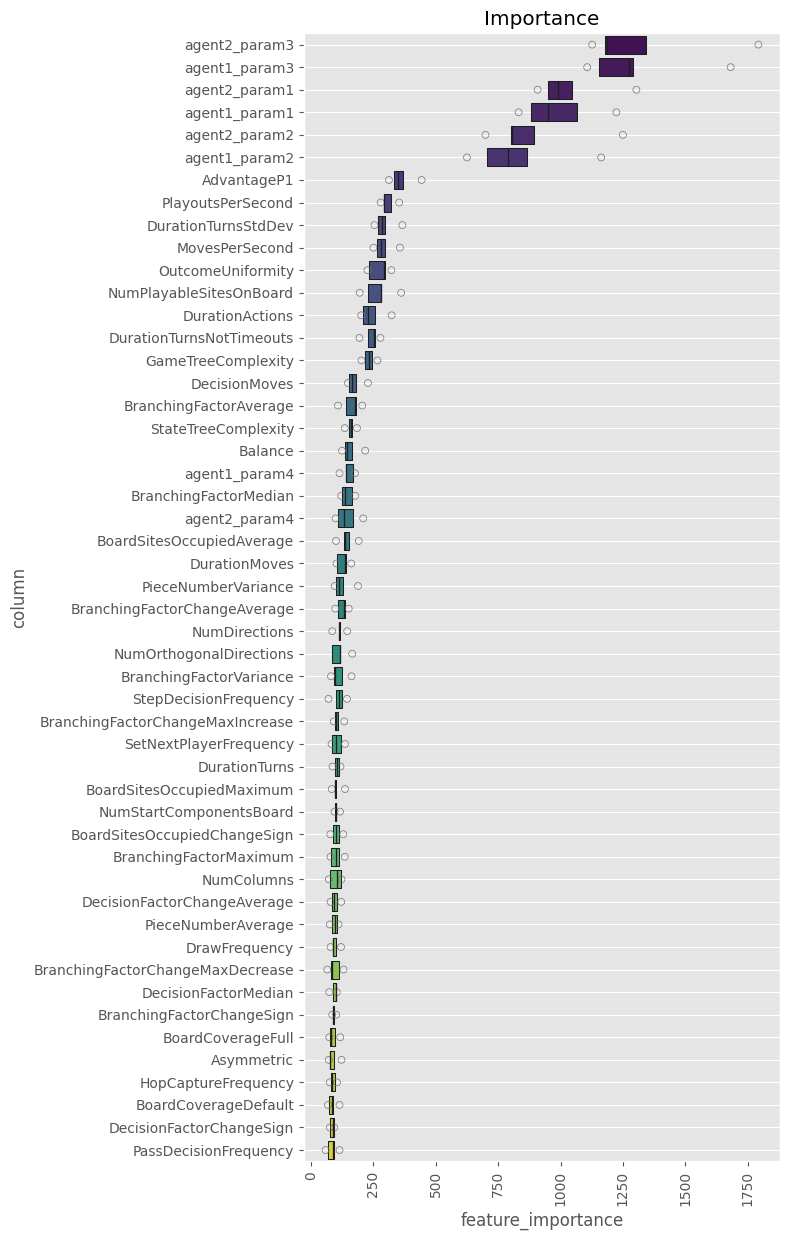

In [35]:
# 参考: https://www.guruguru.science/competitions/24/discussions/5bc8532f-9836-4da9-bfc4-7adc7c1444dd/
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )
    print(feature_importance_df)

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


# 特徴量重要度のプロット
visualize_importance(lgb_models, df_train[train_cols])

In [36]:
preds = np.mean(
    [
        model.predict(df_test[train_cols], num_iteration=model.best_iteration)
        for model in lgb_models
    ],
    0,
)

In [42]:
config.submission_path = r"C:\Users\337587\PlayGround\01_Personal\Kaggle\comp_002_GamePlayingStrength\data\sample_submission.csv"

df_sub = pd.read_csv(config.submission_path)
df_sub[config.target] = preds.reshape(-1, 1) 
df_sub

,Id,utility_agent1
0,233234,0.119464
1,233235,-0.148440
2,233236,0.051456
